# Часть 1: анализ ридов Illumina

## 0. Разобраться с minimap2

In [ ]:
!minimap2 -a reference.fasta pacbio_40x.fq > alignment_pacbio_40x.sam

In [ ]:
!minimap2 -a reference.fasta ONT_2D.fastq > alignment_ONT_2D.sam

In [1]:
# смотрим на статистику PacBio
!samtools flagstat alignment_pacbio_40x.sam

49743 + 0 in total (QC-passed reads + QC-failed reads)
1528 + 0 secondary
6768 + 0 supplementary
0 + 0 duplicates
48434 + 0 mapped (97.37% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [2]:
# смотрим на статистику Oxford Nanopores
!samtools flagstat alignment_ONT_2D.sam

32103 + 0 in total (QC-passed reads + QC-failed reads)
1072 + 0 secondary
221 + 0 supplementary
0 + 0 duplicates
29565 + 0 mapped (92.09% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


## Вычисление статистик

In [3]:
import matplotlib.pyplot as plt
import pysam
import numpy as np
from Bio import SeqIO
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
from IPython.display import set_matplotlib_formats
import seaborn as sns
set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

In [4]:
def get_genome_seq(path):
    return next(SeqIO.parse(path, "fasta")).seq

In [5]:
"""
path_sam -- path of sam file for analyze
len_genome -- length of genome corresponding sam-file

Returns: np.array that represent distribution of coverage by each position

"""
def get_dist_coverage(path_sam, len_genome):
    samfile = pysam.AlignmentFile(path_sam, "rb")
    dist = np.zeros(len_genome)
    for read in samfile.fetch():
        blocks = read.get_blocks()
        for (l, r) in blocks:
            dist[l:r] += 1
    samfile.close()
    return dist

In [6]:
def print_stats(dist_coverage):
    mean_coverage = dist_coverage.mean()
    percent_non_zero_coverage = (dist_coverage.size - dist_coverage[dist_coverage == 0].size) / dist_coverage.size
    print(f"Среднее покрытие: {mean_coverage}")
    print(f"Доля покрытой области генома: {percent_non_zero_coverage}")

In [7]:
def get_mean_array(arr, num_buckets=1000):
    size_bucket = int(arr.size / num_buckets)
    mean_arr = np.zeros(num_buckets)
    for (idx, i) in enumerate(range(0, arr.size - size_bucket, size_bucket)):
        mean_arr[idx] = np.mean(arr[i: i + size_bucket])
    return mean_arr

In [8]:
def get_graph_distr(dist, title, x_name, y_name):
    num_buckets = 1000
    size_bucket = int(dist.size / num_buckets)
    mean_dist = get_mean_array(dist, num_buckets)
    positions = np.array(range(0, dist.size - size_bucket, size_bucket))  
    plt.title(title)   
    plt.xlabel(x_name)   
    plt.ylabel(y_name)   
    plt.plot(positions, mean_dist)   
    plt.show()
    sns.barplot(x=positions, y=mean_dist)

In [16]:
"""
path_sam -- path of sam file for analyze
len_genome -- length of genome corresponding sam-file

Returns: np.array that represent distribution of template length for each read

"""
def get_dist_template_length(path_sam, len_genome):
    samfile = pysam.AlignmentFile(path_sam, "rb")
    dist = np.zeros(len_genome)
    for read in samfile.fetch():
        dist[read.template_length] += 1
    samfile.close()
    return dist

In [17]:
def print_stat_tlens(dist_template_length):
    num_tlen = np.sum(dist_template_length)
    sum_template_length = np.sum(np.arange(dist_template_length.size) * dist_template_length)
    sum_template_length_sq = np.sum((np.arange(dist_template_length.size) ** 2) * dist_template_length)

    mean_template_length = sum_template_length / num_tlen
    std_template_length = np.sqrt(sum_template_length_sq / num_tlen - mean_template_length ** 2)
    print(f"Среднее расстояние вставки: {mean_template_length}")
    print(f"Среднеквадратичное отклонение : {std_template_length}")

In [18]:
def get_presum_reads(path_sam, len_genome):
    samfile = pysam.AlignmentFile(path_sam, "rb")
    end_poss = np.zeros(len_genome)
    presum = np.zeros(len_genome)
    for read in samfile.fetch():
        blocks = read.get_blocks()
        for (l, r) in blocks:
            end_poss[r - 1] += 1
    for (i, el) in enumerate(end_poss):
        if i == 0:
            presum[i] = el
            continue
        presum[i] = presum[i - 1] + el
    
    return presum

# функция для нахождения интервала минимальной ширины в который входит 95% ридов
def print_min_interval(path_sam, len_genome):
    presum = get_presum_reads(path_sam, len_genome)
    min_num_for_95 = int(round(0.95 * presum[-1]))
    len_genome = presum.size
    min_l, min_r = 0, len_genome - 1
    prev_end_pos = 0
    for start_pos in range(len_genome):
        for end_pos in range(prev_end_pos, len_genome):
            if presum[end_pos] - presum[start_pos] > min_num_for_95:
                prev_end_pos = end_pos
                if end_pos - start_pos < min_r - min_l:
                    min_l, min_r = start_pos, end_pos
                break
    print(f"Интервал минимальной ширины, в который попадает 95% ридов: ({min_l}, {min_r})")

In [23]:
def print_dict(d):
    for (i, el) in d.items():
        print(f'{i}  {el}')

In [31]:
BOUND_POLYMER = 3
homopolymers = [BOUND_POLYMER * c for c in ['A', 'G', 'C', 'T']]


def get_genome_seq(path):
    return next(SeqIO.parse(path, "fasta")).seq


def is_left_homopolymer(idx, genome):
    return idx is not None and idx >= BOUND_POLYMER and genome[(idx - BOUND_POLYMER): idx] in homopolymers


def is_right_homopolymer(idx, genome):
    return idx is not None and idx < len(genome) - BOUND_POLYMER and genome[idx: (idx + BOUND_POLYMER)] in homopolymers


"""
:param
    idx - position in genome
    genome - string, representing of genome
    
:returns true, if near idx be polymer
"""
def is_near_homopolymer(idx, genome):
    return idx is not None and is_left_homopolymer(idx, genome) or is_right_homopolymer(idx, genome)

def get_dict_by_numpy(arr):
    res = dict()
    for (i, el) in enumerate(arr):
        if el != 0:
            res[i] = el
    return res


# Процент инделов, находящихся рядом с гомополимерными участками (много одинаковых нуклеотидов подряд)
# Гомополимерным участком считаем по крайней мере 3 одинаковых подряд нуклеотида
"""
:param
    path_sam - path to sam file
    genome - string, representing of genome

:returns indel distribution, percent of indels near homopolymer
"""
def get_dist_indels(path_sam, genome, max_len_read=1000):
    samfile = pysam.AlignmentFile(path_sam, "rb")
    dist = np.zeros(max_len_read, dtype=int)
    num_indels_near_homopolymer = 0
    num_indels = 0
    stat_quality_nucl_error_insert = np.zeros(200, dtype=int)
    stat_quality_nucl_mismatch = np.zeros(200, dtype=int)
    # init matrix
    matrix = dict()
    nucleotids = ['A', 'G', 'C', 'T', 'N', '_']
    for nucl1 in nucleotids:
        for nucl2 in nucleotids:
            matrix[(nucl1, nucl2)] = 0

    percent_errors = []
    for read in samfile.fetch():
        if read.cigartuples is None or read.query_sequence is None:
            continue

        aligned_pairs = read.get_aligned_pairs()
        idx_aligned_pairs = 0
        len_aligned_pairs = len(aligned_pairs)
        qualities = read.get_forward_qualities()

        num_error_in_read = 0
        size_all_blocks = 0
        for op, length in read.cigartuples:
            # skipping hard clipping
            if op == 5:
                continue

            if op == 0 or op == 8: # match or mismatch
                for i in range(idx_aligned_pairs, idx_aligned_pairs + length): # walk by read in which match or mismatch with reference
                    idx_read = aligned_pairs[i][0]
                    idx_reference = aligned_pairs[i][1]
                    char_of_read = read.query_sequence[idx_read].upper()
                    char_of_reference = genome[idx_reference].upper()
                    # update mismatch stat
                    if char_of_read != char_of_reference:
                        num_error_in_read += 1
                        stat_quality_nucl_mismatch[qualities[idx_read]] += 1
                        matrix[(char_of_read, char_of_reference)] += 1

            # consider indels
            if op == 1 or op == 2:
                num_indels += 1
                dist[length] += 1
                idx_genome = aligned_pairs[idx_aligned_pairs][1] if idx_aligned_pairs < len_aligned_pairs else None
                prev_idx_genome = aligned_pairs[idx_aligned_pairs - 1][1] if idx_aligned_pairs != 0 else None
                next_idx_genome = aligned_pairs[idx_aligned_pairs + length][1] if idx_aligned_pairs + length < len_aligned_pairs else None
                # insertion to the reference
                if op == 1:
                    if is_left_homopolymer(prev_idx_genome, genome) or is_right_homopolymer(next_idx_genome, genome):
                        num_indels_near_homopolymer += 1
                    for i in range(idx_aligned_pairs, idx_aligned_pairs + length):
                        idx_read = aligned_pairs[i][0]
                        # update stat for insertion
                        num_error_in_read += 1
                        stat_quality_nucl_error_insert[qualities[idx_read]] += 1
                        char_of_read = read.query_sequence[idx_read].upper()
                        matrix[(char_of_read, '_')] += 1
                # deletion from the reference
                if op == 2:
                    if is_near_homopolymer(idx_genome, genome):
                        num_indels_near_homopolymer += 1
                    for i in range(idx_aligned_pairs, idx_aligned_pairs + length):
                        num_error_in_read += 1
                        idx_reference = aligned_pairs[i][1]
                        char_of_reference = genome[idx_reference]
                        # update stat for deletion
                        matrix[('_', char_of_reference)] += 1

            idx_aligned_pairs += length
            size_all_blocks += length

        percent_errors.append(num_error_in_read / size_all_blocks)

    samfile.close()

    dist_indels = get_dict_by_numpy(dist)
    stat_quality_nucl_error_insert = get_dict_by_numpy(stat_quality_nucl_error_insert)
    stat_quality_nucl_mismatch = get_dict_by_numpy(stat_quality_nucl_mismatch)
    mean_percent_errors = np.mean(percent_errors)
    for nucl in ['A', 'G', 'C', 'T', '_']:
        del matrix[('N', nucl)]
        del matrix[(nucl, 'N')]
    del matrix[('N', 'N')]
    
    return dist_indels, stat_quality_nucl_error_insert, stat_quality_nucl_mismatch, matrix, num_indels_near_homopolymer / num_indels, mean_percent_errors


In [9]:
# read genome
genome = get_genome_seq("reference.fasta")
len_genome = len(genome)

#### pacbio

In [13]:
pacbio_sam = "alignment_pacbio_40x.sam"
pacbio_dist_coverage = get_dist_coverage(pacbio_sam, len_genome)

In [32]:
pacbio_dist_indels, pacbio_stat_quality_nucl_error_insert, pacbio_stat_quality_nucl_mismatch, pacbio_matrix, pacbio_percent_indels_near_homopol, pacbio_mean_percent_errors = get_dist_indels(pacbio_sam, genome, max_len_read=22461)

#### Oxford Nanopores

In [35]:
oxford_sam = "alignment_ONT_2D.sam"
oxford_dist_coverage = get_dist_coverage(oxford_sam, len_genome)

In [38]:
oxford_dist_indels, oxford_stat_quality_nucl_error_insert, oxford_stat_quality_nucl_mismatch, oxford_matrix, oxford_percent_indels_near_homopol, oxford_mean_percent_errors = get_dist_indels(oxford_sam, genome, max_len_read=48521)

## Сравнение результатов

In [51]:
print("Pacbio:")
print_stats(pacbio_dist_coverage)
print()
print("Oxford nanopore:")
print_stats(oxford_dist_coverage)

Pacbio:
Среднее покрытие: 38.53246229531163
Доля покрытой области генома: 1.0

Oxford nanopore:
Среднее покрытие: 26.963127158691073
Доля покрытой области генома: 0.99982584987095


Оба набора ридов почти полностью покрывают геном. Однако у `pacbio` среднее покрытие выше. 

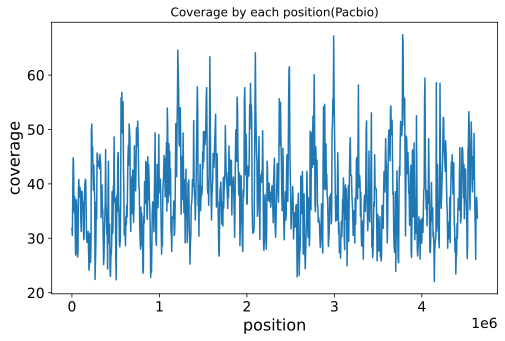

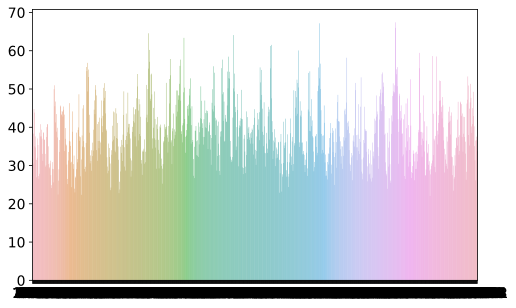

In [52]:
get_graph_distr(pacbio_dist_coverage, title='Coverage by each position(Pacbio)', x_name='position', y_name='coverage')

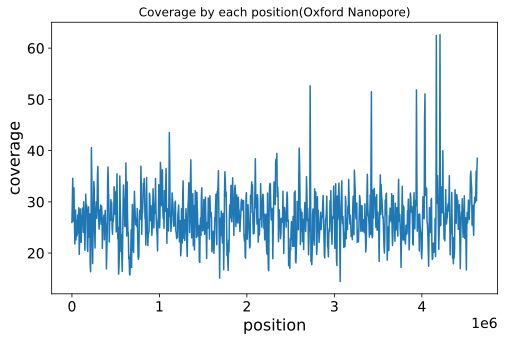

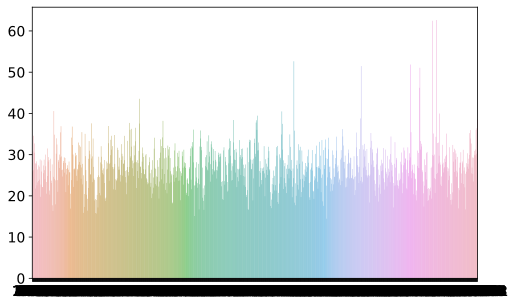

In [53]:
get_graph_distr(oxford_dist_coverage, title='Coverage by each position(Oxford Nanopore)', x_name='position', y_name='coverage')

In [54]:
print(f"Средний процент ошибок в ридах в Pacbio: {pacbio_mean_percent_errors}")
print(f"Средний процент ошибок в ридах в Oxford Nanopore : {oxford_mean_percent_errors}")

Средний процент ошибок в ридах в Pacbio: 0.12282984902167837
Средний процент ошибок в ридах в Oxford Nanopore : 0.07506827837199548


То есть `error_rate` в `Pacbio` получился равным 12% (что немного превышает заявленный (2-10%) на 2 процента), а в `Oxford Nanopore` 7.5% (что соответствует заявленному(5-15%)).

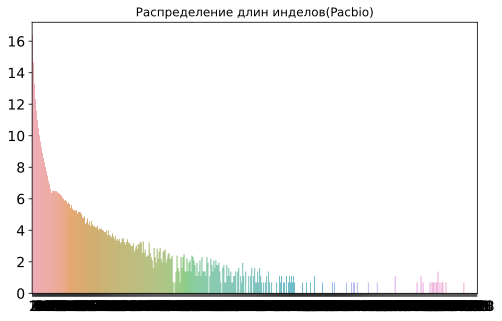

In [55]:
sns.barplot(x=list(pacbio_dist_indels.keys()), y=np.log(list(pacbio_dist_indels.values()))).set_title("Распределение длин инделов(Pacbio)")

plt.show()

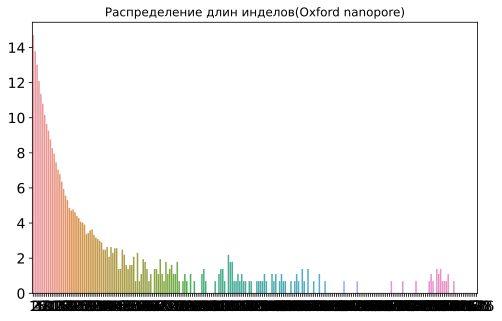

In [56]:
sns.barplot(x=list(oxford_dist_indels.keys()), y=np.log(list(oxford_dist_indels.values()))).set_title("Распределение длин инделов(Oxford nanopore)")

plt.show()

Как видно из распределения длин инделов -- `Oxford Nanopore` имеет больше инделов небольшой длины, чем `Pacbio`

In [57]:
print("Таблица частот замен/вставок/удалений у Pacbio:")
print_dict(pacbio_matrix)

Таблица частот замен/вставок/удалений у Pacbio:
('A', 'A')  0
('A', 'G')  322254
('A', 'C')  457338
('A', 'T')  285699
('A', '_')  3595384
('G', 'A')  307539
('G', 'G')  0
('G', 'C')  414331
('G', 'T')  359744
('G', '_')  4483786
('C', 'A')  354487
('C', 'G')  415583
('C', 'C')  0
('C', 'T')  309393
('C', '_')  4480844
('T', 'A')  285427
('T', 'G')  450152
('T', 'C')  321990
('T', 'T')  0
('T', '_')  3577631
('_', 'A')  1439867
('_', 'G')  2067558
('_', 'C')  2074963
('_', 'T')  1436033
('_', '_')  0


In [58]:
print("Таблица частот замен/вставок/удалений у Oxford Nanopore:")
print_dict(oxford_matrix)

Таблица частот замен/вставок/удалений у Oxford Nanopore:
('A', 'A')  0
('A', 'G')  319761
('A', 'C')  137046
('A', 'T')  107765
('A', '_')  398409
('G', 'A')  368487
('G', 'G')  0
('G', 'C')  85027
('G', 'T')  111447
('G', '_')  394700
('C', 'A')  112963
('C', 'G')  91353
('C', 'C')  0
('C', 'T')  372780
('C', '_')  378519
('T', 'A')  105373
('T', 'G')  126487
('T', 'C')  340675
('T', 'T')  0
('T', '_')  394386
('_', 'A')  1608029
('_', 'G')  1559017
('_', 'C')  1537154
('_', 'T')  1604787
('_', '_')  0


Таблицы замен/вставок/удалений для обоих наборов ридов примерно одинаковые.